In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'squeezeNet/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('SqueezeNet Classifier. First Test. No global clipnorm.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                #img = aug['image'] / 255.0
                img = aug['image'] 
            except:
                #print(f'Error trying to augment image {img_file}')
                # img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                # img = (img / 255.0) - 0.5 
                # img = torch.tensor(img, dtype=torch.float32)
                # img = img.permute(2, 0, 1)
                aug = self.except_transform(image=img)
                img = aug['image'] 
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

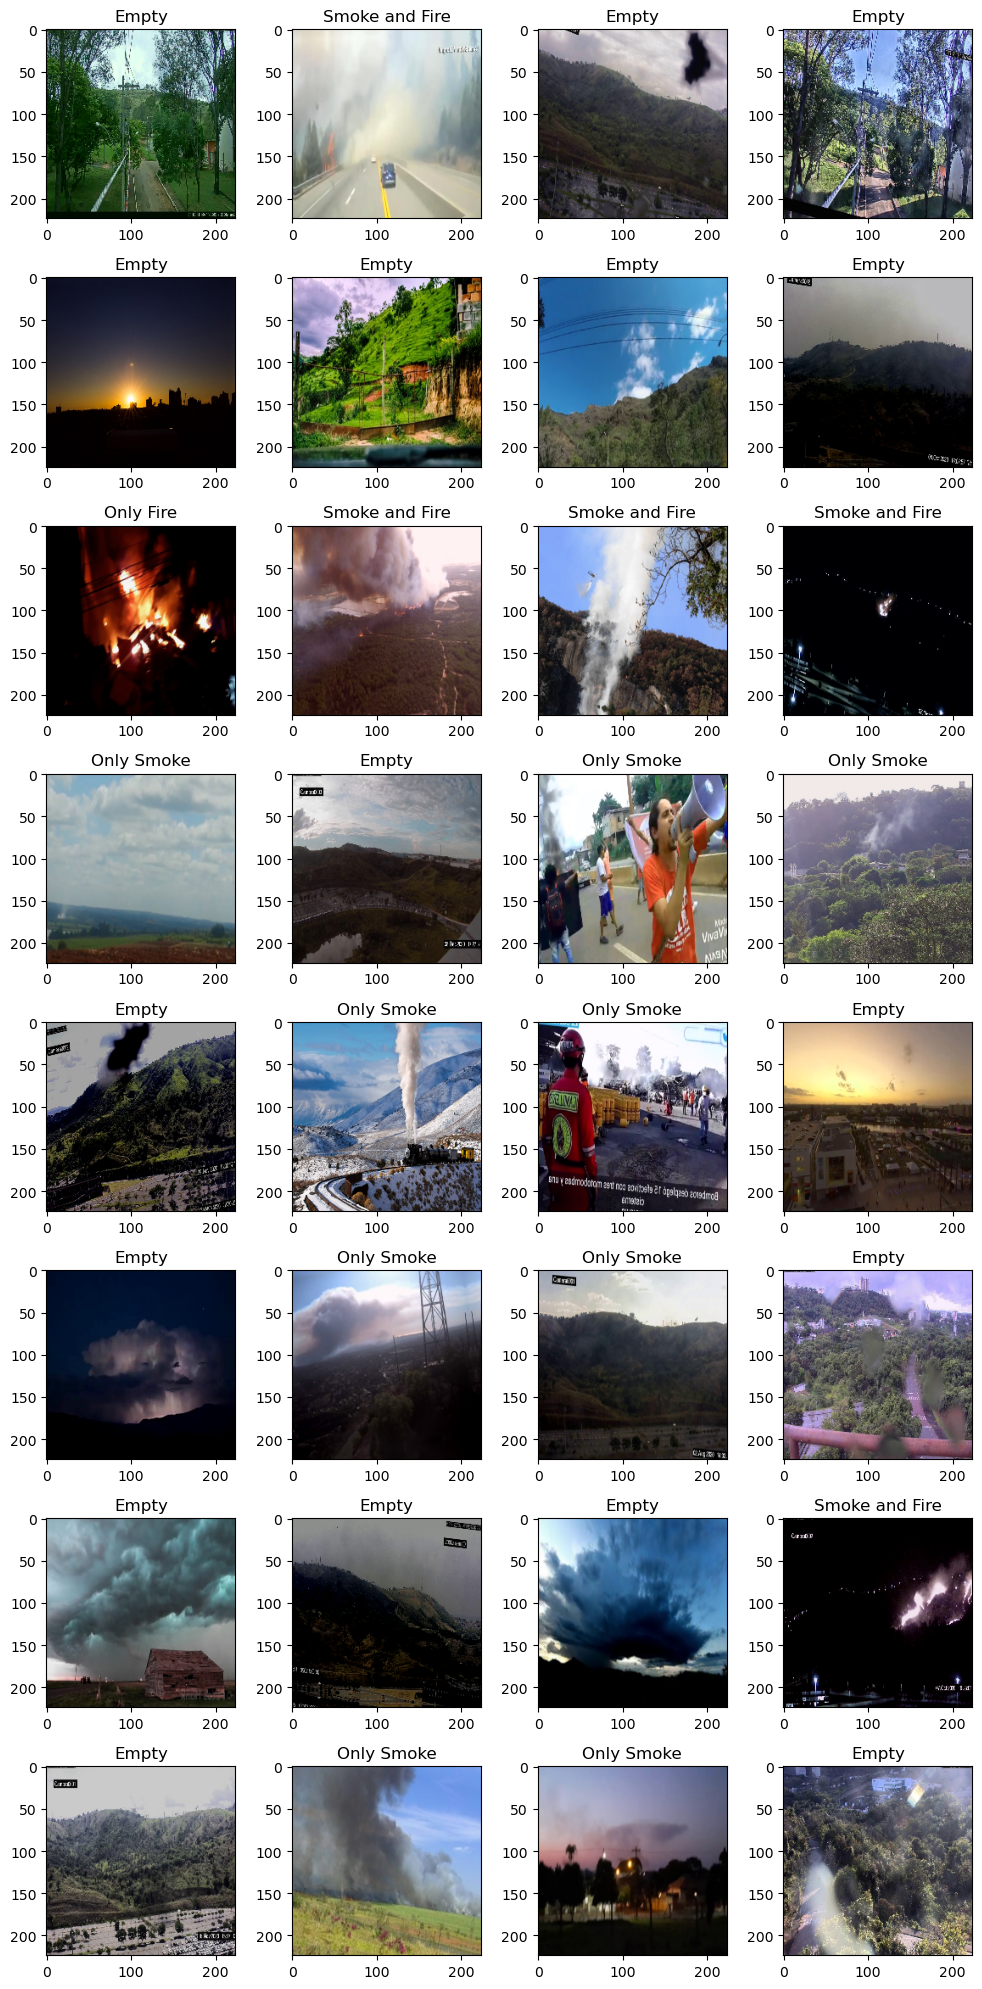

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: SqueezeNet

In [10]:
class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU()
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU()
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )


class SqueezeNet(nn.Module):
    def __init__(self, num_classes: int = 2, dropout: float = 0.5) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
            # Final convolution
        )

        # Final convolution is initialized differently from the rest
        smoke_final_conv = nn.Conv2d(512, 1, kernel_size=1)
        fire_final_conv = nn.Conv2d(512, 1, kernel_size=1)
        self.smoke = nn.Sequential(
            nn.Dropout(p=dropout),
            smoke_final_conv,
            nn.ReLU(), 
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=1, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=dropout),
            fire_final_conv,
            nn.ReLU(), 
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=1, out_features=1)
        )

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         if m is smoke_final_conv:
        #             nn.init.normal_(m.weight, mean=0.0, std=0.01)
        #         elif m is fire_final_conv:
        #             nn.init.normal_(m.weight, mean=0.0, std=0.01)
        #         else:
        #             nn.init.kaiming_uniform_(m.weight)
        #         if m.bias is not None:
        #             nn.init.constant_(m.bias, 0)
        #     elif isinstance(m, nn.Linear):
        #         nn.init.normal_(m.weight, 0, 0.01)
        #         nn.init.constant_(m.bias, 0)
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        smoke = self.smoke(x)
        fire = self.fire(x)
        x = torch.cat((smoke, fire), dim=-1)
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device):
        super(BCE_LOSS, self).__init__()
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce(predictions[..., 0],
                              ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce(predictions[..., 1],
                             ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [22]:
''' ============================
    Hyperparameters and More
============================ '''

#MODEL = "BED"
MODEL = "SQUEEZE"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 75 #100
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + "squeeze_classifier_best.pt"

LOSS_FN = "BCE"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [21]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using Squeeze Classifier
Model shape is tensor([[ 0.1284, -0.7853],
        [ 0.1255, -0.7848],
        [ 0.1257, -0.7849],
        [ 0.1253, -0.7856]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU()
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU()
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU()
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU()
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU()
      (expand

# Main Function

In [23]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        loss_fn = BCE_LOSS(device=DEVICE)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_best_classifier.pt')    
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + MODEL + 'last_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [24]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    squeeze_model = main()

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE

***Start Training: 18:43:53

Initializing Weights

=== EPOCH 0/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
71.833      |44.070      |27.763      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
66.099      |43.152      |22.947      

SMOKE -> Precision: 0.610 - Recall: 0.437 - Accuracy: 0.595 - F1: 0.509
FIRE -> Precision: 0.722 - Recall: 0.668 - Accuracy: 0.847 - F1: 0.694

Saving model with new best validation loss: 66.099

=== EPOCH 1/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
66.618      |43.057      |23.561      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
66.515      |42.437      |24.078      

SMOKE -> Precision: 0.627 - Recall: 0.592 - Accuracy: 0.634 - F1: 0.609
FIRE -> Precision: 0.647 - Recall: 0.896 - Accuracy: 0.846 - F1: 0.751

=== EPOCH 2/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:48<00:00,  5.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
64.689      |42.504      |22.185      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.924      |42.637      |20.287      

SMOKE -> Precision: 0.636 - Recall: 0.469 - Accuracy: 0.615 - F1: 0.540
FIRE -> Precision: 0.739 - Recall: 0.755 - Accuracy: 0.868 - F1: 0.747

Saving model with new best validation loss: 62.924

=== EPOCH 3/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.881      |41.528      |21.353      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.462      |40.137      |18.325      

SMOKE -> Precision: 0.636 - Recall: 0.670 - Accuracy: 0.657 - F1: 0.653
FIRE -> Precision: 0.749 - Recall: 0.814 - Accuracy: 0.881 - F1: 0.780

Saving model with new best validation loss: 58.462

=== EPOCH 4/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.232      |40.530      |19.702      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.308      |38.260      |18.048      

SMOKE -> Precision: 0.666 - Recall: 0.716 - Accuracy: 0.691 - F1: 0.690
FIRE -> Precision: 0.742 - Recall: 0.868 - Accuracy: 0.888 - F1: 0.800

Saving model with new best validation loss: 56.308

=== EPOCH 5/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.634      |39.328      |19.306      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.884      |38.085      |17.799      

SMOKE -> Precision: 0.698 - Recall: 0.555 - Accuracy: 0.670 - F1: 0.618
FIRE -> Precision: 0.723 - Recall: 0.900 - Accuracy: 0.885 - F1: 0.802

Saving model with new best validation loss: 55.884

=== EPOCH 6/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.004      |38.664      |18.340      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.642      |36.733      |16.910      

SMOKE -> Precision: 0.704 - Recall: 0.689 - Accuracy: 0.711 - F1: 0.697
FIRE -> Precision: 0.744 - Recall: 0.895 - Accuracy: 0.893 - F1: 0.812

Saving model with new best validation loss: 53.642

=== EPOCH 7/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.397      |38.078      |18.319      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.673      |36.037      |16.637      

SMOKE -> Precision: 0.684 - Recall: 0.762 - Accuracy: 0.716 - F1: 0.721
FIRE -> Precision: 0.745 - Recall: 0.889 - Accuracy: 0.893 - F1: 0.811

Saving model with new best validation loss: 52.673

=== EPOCH 8/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.037      |37.726      |18.311      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.986      |36.630      |18.356      

SMOKE -> Precision: 0.703 - Recall: 0.724 - Accuracy: 0.720 - F1: 0.713
FIRE -> Precision: 0.813 - Recall: 0.762 - Accuracy: 0.893 - F1: 0.787

=== EPOCH 9/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.714      |37.382      |17.332      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.620      |35.232      |15.388      

SMOKE -> Precision: 0.729 - Recall: 0.672 - Accuracy: 0.722 - F1: 0.699
FIRE -> Precision: 0.798 - Recall: 0.853 - Accuracy: 0.906 - F1: 0.825

Saving model with new best validation loss: 50.620

=== EPOCH 10/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.020      |36.170      |16.851      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.094      |34.375      |15.719      

SMOKE -> Precision: 0.716 - Recall: 0.723 - Accuracy: 0.729 - F1: 0.719
FIRE -> Precision: 0.827 - Recall: 0.839 - Accuracy: 0.913 - F1: 0.833

Saving model with new best validation loss: 50.094

=== EPOCH 11/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.251      |35.667      |16.585      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.819      |33.217      |14.602      

SMOKE -> Precision: 0.744 - Recall: 0.733 - Accuracy: 0.750 - F1: 0.739
FIRE -> Precision: 0.823 - Recall: 0.860 - Accuracy: 0.916 - F1: 0.841

Saving model with new best validation loss: 47.819

=== EPOCH 12/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.533      |35.450      |16.084      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.341      |33.296      |15.045      

SMOKE -> Precision: 0.715 - Recall: 0.791 - Accuracy: 0.748 - F1: 0.751
FIRE -> Precision: 0.833 - Recall: 0.811 - Accuracy: 0.909 - F1: 0.822

=== EPOCH 13/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.494      |35.484      |16.010      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.870      |33.153      |13.717      

SMOKE -> Precision: 0.710 - Recall: 0.800 - Accuracy: 0.747 - F1: 0.752
FIRE -> Precision: 0.862 - Recall: 0.830 - Accuracy: 0.922 - F1: 0.846

Saving model with new best validation loss: 46.870

=== EPOCH 14/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.845      |34.561      |15.284      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.151      |32.442      |13.709      

SMOKE -> Precision: 0.743 - Recall: 0.740 - Accuracy: 0.752 - F1: 0.742
FIRE -> Precision: 0.819 - Recall: 0.887 - Accuracy: 0.920 - F1: 0.852

Saving model with new best validation loss: 46.151

=== EPOCH 15/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.365      |34.165      |15.200      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.020      |33.293      |13.726      

SMOKE -> Precision: 0.670 - Recall: 0.893 - Accuracy: 0.737 - F1: 0.766
FIRE -> Precision: 0.804 - Recall: 0.896 - Accuracy: 0.917 - F1: 0.848

=== EPOCH 16/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.142      |33.452      |14.690      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.697      |30.657      |13.040      

SMOKE -> Precision: 0.751 - Recall: 0.798 - Accuracy: 0.776 - F1: 0.774
FIRE -> Precision: 0.855 - Recall: 0.852 - Accuracy: 0.924 - F1: 0.854

Saving model with new best validation loss: 43.697

=== EPOCH 17/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.477      |33.277      |14.200      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.238      |31.341      |13.897      

SMOKE -> Precision: 0.738 - Recall: 0.796 - Accuracy: 0.766 - F1: 0.766
FIRE -> Precision: 0.827 - Recall: 0.877 - Accuracy: 0.921 - F1: 0.851

=== EPOCH 18/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.129      |32.860      |14.269      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.804      |31.230      |12.574      

SMOKE -> Precision: 0.787 - Recall: 0.709 - Accuracy: 0.768 - F1: 0.746
FIRE -> Precision: 0.830 - Recall: 0.900 - Accuracy: 0.927 - F1: 0.864

=== EPOCH 19/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.337      |32.557      |13.781      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.829      |30.561      |12.269      

SMOKE -> Precision: 0.757 - Recall: 0.757 - Accuracy: 0.766 - F1: 0.757
FIRE -> Precision: 0.843 - Recall: 0.889 - Accuracy: 0.928 - F1: 0.865

Saving model with new best validation loss: 42.829

=== EPOCH 20/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.071      |32.421      |13.651      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.698      |31.275      |13.424      

SMOKE -> Precision: 0.736 - Recall: 0.794 - Accuracy: 0.764 - F1: 0.764
FIRE -> Precision: 0.795 - Recall: 0.913 - Accuracy: 0.917 - F1: 0.850

=== EPOCH 21/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.832      |32.443      |13.389      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.980      |30.225      |11.755      

SMOKE -> Precision: 0.715 - Recall: 0.905 - Accuracy: 0.781 - F1: 0.799
FIRE -> Precision: 0.837 - Recall: 0.905 - Accuracy: 0.930 - F1: 0.870

Saving model with new best validation loss: 41.980

=== EPOCH 22/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.764      |31.761      |13.003      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.706      |30.946      |11.760      

SMOKE -> Precision: 0.789 - Recall: 0.733 - Accuracy: 0.778 - F1: 0.760
FIRE -> Precision: 0.864 - Recall: 0.871 - Accuracy: 0.931 - F1: 0.868

=== EPOCH 23/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.193      |31.398      |12.795      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.410      |29.022      |11.388      

SMOKE -> Precision: 0.789 - Recall: 0.790 - Accuracy: 0.798 - F1: 0.790
FIRE -> Precision: 0.871 - Recall: 0.899 - Accuracy: 0.939 - F1: 0.885

Saving model with new best validation loss: 40.410

=== EPOCH 24/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.493      |31.026      |12.467      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.722      |29.624      |11.098      

SMOKE -> Precision: 0.813 - Recall: 0.688 - Accuracy: 0.774 - F1: 0.745
FIRE -> Precision: 0.891 - Recall: 0.873 - Accuracy: 0.940 - F1: 0.882

=== EPOCH 25/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.111      |30.701      |12.410      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.871      |28.853      |11.018      

SMOKE -> Precision: 0.743 - Recall: 0.878 - Accuracy: 0.795 - F1: 0.805
FIRE -> Precision: 0.868 - Recall: 0.905 - Accuracy: 0.940 - F1: 0.886

Saving model with new best validation loss: 39.871

=== EPOCH 26/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.522      |30.484      |12.038      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.475      |27.911      |11.564      

SMOKE -> Precision: 0.760 - Recall: 0.871 - Accuracy: 0.805 - F1: 0.811
FIRE -> Precision: 0.818 - Recall: 0.927 - Accuracy: 0.928 - F1: 0.869

Saving model with new best validation loss: 39.475

=== EPOCH 27/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.206      |30.369      |11.837      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.319      |28.087      |10.232      

SMOKE -> Precision: 0.742 - Recall: 0.912 - Accuracy: 0.805 - F1: 0.818
FIRE -> Precision: 0.870 - Recall: 0.907 - Accuracy: 0.941 - F1: 0.888

Saving model with new best validation loss: 38.319

=== EPOCH 28/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.031      |30.228      |11.802      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.369      |27.055      |11.315      

SMOKE -> Precision: 0.817 - Recall: 0.799 - Accuracy: 0.817 - F1: 0.808
FIRE -> Precision: 0.829 - Recall: 0.929 - Accuracy: 0.932 - F1: 0.876

=== EPOCH 29/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.386      |29.886      |11.500      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.308      |27.979      |10.329      

SMOKE -> Precision: 0.749 - Recall: 0.879 - Accuracy: 0.800 - F1: 0.809
FIRE -> Precision: 0.880 - Recall: 0.909 - Accuracy: 0.944 - F1: 0.894

Saving model with new best validation loss: 38.308

=== EPOCH 30/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.343      |29.177      |11.166      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.529      |27.364      |10.165      

SMOKE -> Precision: 0.805 - Recall: 0.777 - Accuracy: 0.802 - F1: 0.791
FIRE -> Precision: 0.900 - Recall: 0.877 - Accuracy: 0.943 - F1: 0.889

Saving model with new best validation loss: 37.529

=== EPOCH 31/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.609      |29.187      |11.423      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.844      |26.361      |10.482      

SMOKE -> Precision: 0.799 - Recall: 0.836 - Accuracy: 0.820 - F1: 0.817
FIRE -> Precision: 0.857 - Recall: 0.909 - Accuracy: 0.937 - F1: 0.882

Saving model with new best validation loss: 36.844

=== EPOCH 32/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.676      |28.548      |11.128      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.055      |26.198      |9.857       

SMOKE -> Precision: 0.792 - Recall: 0.858 - Accuracy: 0.823 - F1: 0.824
FIRE -> Precision: 0.897 - Recall: 0.886 - Accuracy: 0.944 - F1: 0.892

Saving model with new best validation loss: 36.055

=== EPOCH 33/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.069      |28.706      |11.362      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.317      |26.396      |9.921       

SMOKE -> Precision: 0.773 - Recall: 0.880 - Accuracy: 0.818 - F1: 0.823
FIRE -> Precision: 0.890 - Recall: 0.895 - Accuracy: 0.944 - F1: 0.893

=== EPOCH 34/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.448      |28.465      |10.983      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.215      |25.836      |9.379       

SMOKE -> Precision: 0.772 - Recall: 0.878 - Accuracy: 0.817 - F1: 0.822
FIRE -> Precision: 0.895 - Recall: 0.903 - Accuracy: 0.948 - F1: 0.899

Saving model with new best validation loss: 35.215

=== EPOCH 35/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.319      |28.339      |10.980      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.582      |26.248      |9.334       

SMOKE -> Precision: 0.820 - Recall: 0.818 - Accuracy: 0.826 - F1: 0.819
FIRE -> Precision: 0.911 - Recall: 0.892 - Accuracy: 0.949 - F1: 0.901

=== EPOCH 36/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.248      |28.137      |11.111      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.004      |25.595      |10.409      

SMOKE -> Precision: 0.820 - Recall: 0.839 - Accuracy: 0.834 - F1: 0.830
FIRE -> Precision: 0.856 - Recall: 0.932 - Accuracy: 0.942 - F1: 0.892

=== EPOCH 37/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.778      |27.534      |10.243      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.148      |25.497      |9.651       

SMOKE -> Precision: 0.797 - Recall: 0.865 - Accuracy: 0.829 - F1: 0.830
FIRE -> Precision: 0.867 - Recall: 0.920 - Accuracy: 0.943 - F1: 0.892

Saving model with new best validation loss: 35.148

=== EPOCH 38/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.988      |27.532      |10.456      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.683      |25.796      |9.888       

SMOKE -> Precision: 0.776 - Recall: 0.896 - Accuracy: 0.826 - F1: 0.832
FIRE -> Precision: 0.855 - Recall: 0.939 - Accuracy: 0.943 - F1: 0.895

=== EPOCH 39/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.468      |27.236      |10.232      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.577      |24.415      |9.161       

SMOKE -> Precision: 0.829 - Recall: 0.830 - Accuracy: 0.836 - F1: 0.829
FIRE -> Precision: 0.904 - Recall: 0.904 - Accuracy: 0.950 - F1: 0.904

Saving model with new best validation loss: 33.577

=== EPOCH 40/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.213      |26.994      |10.218      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.650      |26.112      |9.538       

SMOKE -> Precision: 0.804 - Recall: 0.833 - Accuracy: 0.822 - F1: 0.819
FIRE -> Precision: 0.888 - Recall: 0.912 - Accuracy: 0.948 - F1: 0.900

=== EPOCH 41/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.642      |27.501      |10.142      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.222      |24.302      |9.920       

SMOKE -> Precision: 0.827 - Recall: 0.836 - Accuracy: 0.837 - F1: 0.831
FIRE -> Precision: 0.852 - Recall: 0.944 - Accuracy: 0.943 - F1: 0.896

=== EPOCH 42/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.667      |26.690      |9.977       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.883      |23.701      |9.182       

SMOKE -> Precision: 0.798 - Recall: 0.899 - Accuracy: 0.842 - F1: 0.846
FIRE -> Precision: 0.894 - Recall: 0.903 - Accuracy: 0.947 - F1: 0.898

Saving model with new best validation loss: 32.883

=== EPOCH 43/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.420      |26.377      |10.043      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.290      |24.075      |9.215       

SMOKE -> Precision: 0.786 - Recall: 0.899 - Accuracy: 0.833 - F1: 0.839
FIRE -> Precision: 0.874 - Recall: 0.930 - Accuracy: 0.947 - F1: 0.901

=== EPOCH 44/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.516      |25.881      |9.634       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.333      |23.557      |8.777       

SMOKE -> Precision: 0.840 - Recall: 0.835 - Accuracy: 0.844 - F1: 0.837
FIRE -> Precision: 0.929 - Recall: 0.879 - Accuracy: 0.951 - F1: 0.903

Saving model with new best validation loss: 32.333

=== EPOCH 45/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.920      |26.237      |9.684       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.114      |23.069      |9.044       

SMOKE -> Precision: 0.824 - Recall: 0.863 - Accuracy: 0.845 - F1: 0.843
FIRE -> Precision: 0.898 - Recall: 0.922 - Accuracy: 0.953 - F1: 0.910

Saving model with new best validation loss: 32.114

=== EPOCH 46/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.468      |25.892      |9.576       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.302      |22.664      |8.638       

SMOKE -> Precision: 0.822 - Recall: 0.875 - Accuracy: 0.849 - F1: 0.848
FIRE -> Precision: 0.904 - Recall: 0.913 - Accuracy: 0.952 - F1: 0.908

Saving model with new best validation loss: 31.302

=== EPOCH 47/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.959      |25.431      |9.527       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.008      |23.198      |8.810       

SMOKE -> Precision: 0.793 - Recall: 0.925 - Accuracy: 0.848 - F1: 0.854
FIRE -> Precision: 0.897 - Recall: 0.918 - Accuracy: 0.951 - F1: 0.907

=== EPOCH 48/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.270      |25.015      |9.255       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.159      |22.582      |8.577       

SMOKE -> Precision: 0.848 - Recall: 0.843 - Accuracy: 0.852 - F1: 0.845
FIRE -> Precision: 0.894 - Recall: 0.923 - Accuracy: 0.951 - F1: 0.908

Saving model with new best validation loss: 31.159

=== EPOCH 49/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.301      |24.867      |9.434       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.967      |22.676      |8.291       

SMOKE -> Precision: 0.797 - Recall: 0.933 - Accuracy: 0.854 - F1: 0.860
FIRE -> Precision: 0.917 - Recall: 0.913 - Accuracy: 0.956 - F1: 0.915

Saving model with new best validation loss: 30.967

=== EPOCH 50/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.068      |24.825      |9.243       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.108      |21.696      |8.412       

SMOKE -> Precision: 0.826 - Recall: 0.898 - Accuracy: 0.860 - F1: 0.861
FIRE -> Precision: 0.890 - Recall: 0.927 - Accuracy: 0.951 - F1: 0.908

Saving model with new best validation loss: 30.108

=== EPOCH 51/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.375      |25.118      |9.256       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.864      |21.427      |8.437       

SMOKE -> Precision: 0.847 - Recall: 0.869 - Accuracy: 0.861 - F1: 0.858
FIRE -> Precision: 0.925 - Recall: 0.910 - Accuracy: 0.958 - F1: 0.917

Saving model with new best validation loss: 29.864

=== EPOCH 52/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.367      |24.446      |8.921       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.946      |20.898      |8.048       

SMOKE -> Precision: 0.831 - Recall: 0.905 - Accuracy: 0.866 - F1: 0.867
FIRE -> Precision: 0.919 - Recall: 0.910 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 28.946

=== EPOCH 53/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.192      |24.100      |9.092       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.701      |22.279      |8.423       

SMOKE -> Precision: 0.869 - Recall: 0.824 - Accuracy: 0.855 - F1: 0.846
FIRE -> Precision: 0.903 - Recall: 0.927 - Accuracy: 0.955 - F1: 0.915

=== EPOCH 54/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.644      |24.551      |9.093       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.371      |21.234      |8.137       

SMOKE -> Precision: 0.859 - Recall: 0.843 - Accuracy: 0.858 - F1: 0.851
FIRE -> Precision: 0.939 - Recall: 0.898 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 55/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.644      |23.856      |8.787       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.566      |21.297      |8.268       

SMOKE -> Precision: 0.859 - Recall: 0.863 - Accuracy: 0.866 - F1: 0.861
FIRE -> Precision: 0.919 - Recall: 0.907 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 56/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.244      |22.769      |8.475       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.363      |21.575      |7.788       

SMOKE -> Precision: 0.853 - Recall: 0.856 - Accuracy: 0.860 - F1: 0.855
FIRE -> Precision: 0.916 - Recall: 0.919 - Accuracy: 0.957 - F1: 0.918

=== EPOCH 57/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.011      |22.675      |8.336       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.269      |19.420      |7.850       

SMOKE -> Precision: 0.852 - Recall: 0.914 - Accuracy: 0.882 - F1: 0.882
FIRE -> Precision: 0.938 - Recall: 0.899 - Accuracy: 0.958 - F1: 0.918

Saving model with new best validation loss: 27.269

=== EPOCH 58/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.028      |22.774      |8.254       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.585      |20.347      |8.238       

SMOKE -> Precision: 0.836 - Recall: 0.904 - Accuracy: 0.868 - F1: 0.869
FIRE -> Precision: 0.895 - Recall: 0.927 - Accuracy: 0.953 - F1: 0.911

=== EPOCH 59/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.742      |22.579      |8.163       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.443      |19.594      |7.850       

SMOKE -> Precision: 0.843 - Recall: 0.913 - Accuracy: 0.877 - F1: 0.877
FIRE -> Precision: 0.892 - Recall: 0.948 - Accuracy: 0.957 - F1: 0.919

=== EPOCH 60/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.295      |21.883      |8.411       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.114      |19.887      |8.227       

SMOKE -> Precision: 0.875 - Recall: 0.861 - Accuracy: 0.874 - F1: 0.868
FIRE -> Precision: 0.894 - Recall: 0.925 - Accuracy: 0.952 - F1: 0.909

=== EPOCH 61/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.126      |21.269      |7.857       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.123      |19.049      |8.074       

SMOKE -> Precision: 0.846 - Recall: 0.908 - Accuracy: 0.876 - F1: 0.876
FIRE -> Precision: 0.902 - Recall: 0.916 - Accuracy: 0.952 - F1: 0.909

Saving model with new best validation loss: 27.123

=== EPOCH 62/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.936      |21.229      |7.707       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.577      |18.949      |8.628       

SMOKE -> Precision: 0.845 - Recall: 0.911 - Accuracy: 0.877 - F1: 0.877
FIRE -> Precision: 0.876 - Recall: 0.950 - Accuracy: 0.952 - F1: 0.912

=== EPOCH 63/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.954      |21.094      |7.859       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.192      |18.877      |7.315       

SMOKE -> Precision: 0.872 - Recall: 0.872 - Accuracy: 0.877 - F1: 0.872
FIRE -> Precision: 0.935 - Recall: 0.917 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 26.192

=== EPOCH 64/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.536      |21.089      |7.446       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.154      |19.490      |7.663       

SMOKE -> Precision: 0.877 - Recall: 0.861 - Accuracy: 0.875 - F1: 0.869
FIRE -> Precision: 0.940 - Recall: 0.895 - Accuracy: 0.958 - F1: 0.917

=== EPOCH 65/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.347      |20.958      |7.389       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.065      |18.517      |7.548       

SMOKE -> Precision: 0.875 - Recall: 0.885 - Accuracy: 0.884 - F1: 0.880
FIRE -> Precision: 0.917 - Recall: 0.923 - Accuracy: 0.958 - F1: 0.920

Saving model with new best validation loss: 26.065

=== EPOCH 66/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.405      |20.924      |7.481       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.106      |18.531      |7.574       

SMOKE -> Precision: 0.872 - Recall: 0.906 - Accuracy: 0.891 - F1: 0.889
FIRE -> Precision: 0.936 - Recall: 0.904 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 67/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.371      |20.171      |7.200       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.309      |20.225      |8.083       

SMOKE -> Precision: 0.812 - Recall: 0.938 - Accuracy: 0.866 - F1: 0.870
FIRE -> Precision: 0.890 - Recall: 0.937 - Accuracy: 0.954 - F1: 0.913

=== EPOCH 68/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.623      |20.339      |7.284       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.435      |17.877      |7.558       

SMOKE -> Precision: 0.887 - Recall: 0.883 - Accuracy: 0.890 - F1: 0.885
FIRE -> Precision: 0.922 - Recall: 0.911 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 25.435

=== EPOCH 69/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.532      |20.104      |7.427       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.093      |18.496      |7.598       

SMOKE -> Precision: 0.886 - Recall: 0.873 - Accuracy: 0.885 - F1: 0.879
FIRE -> Precision: 0.891 - Recall: 0.944 - Accuracy: 0.956 - F1: 0.917

=== EPOCH 70/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.912      |19.563      |7.349       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.138      |17.487      |7.651       

SMOKE -> Precision: 0.857 - Recall: 0.937 - Accuracy: 0.894 - F1: 0.895
FIRE -> Precision: 0.892 - Recall: 0.941 - Accuracy: 0.955 - F1: 0.915

Saving model with new best validation loss: 25.138

=== EPOCH 71/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.289      |20.112      |7.177       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.570      |18.820      |7.751       

SMOKE -> Precision: 0.884 - Recall: 0.868 - Accuracy: 0.882 - F1: 0.876
FIRE -> Precision: 0.899 - Recall: 0.941 - Accuracy: 0.957 - F1: 0.919

=== EPOCH 72/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.974      |19.886      |7.088       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.145      |17.976      |8.169       

SMOKE -> Precision: 0.863 - Recall: 0.902 - Accuracy: 0.884 - F1: 0.882
FIRE -> Precision: 0.890 - Recall: 0.941 - Accuracy: 0.955 - F1: 0.915

=== EPOCH 73/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.241      |20.090      |7.151       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.592      |17.874      |7.718       

SMOKE -> Precision: 0.867 - Recall: 0.906 - Accuracy: 0.888 - F1: 0.886
FIRE -> Precision: 0.901 - Recall: 0.941 - Accuracy: 0.958 - F1: 0.921

=== EPOCH 74/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.678      |18.927      |6.751       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.399      |17.243      |7.156       

SMOKE -> Precision: 0.881 - Recall: 0.907 - Accuracy: 0.896 - F1: 0.894
FIRE -> Precision: 0.935 - Recall: 0.916 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 24.399

***Script finished: 19:54:07

Time elapsed: 1:10:13.944876


# Plot Results

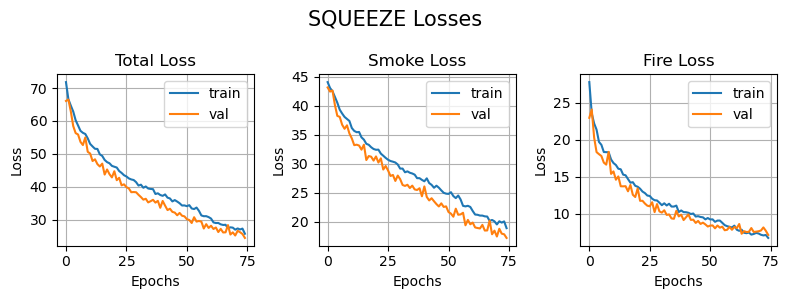

In [25]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle(MODEL + ' Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + MODEL + "_losses.png")
plt.show()